In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import morphology
from skimage.measure import regionprops
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Step 1: Load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (256, 256))  
            images.append(img)
    return images

In [3]:
image_folder = './Image_gen/2k_image_cell_types/'
images = load_images_from_folder(image_folder)

In [4]:
# Step 2: U-Net Architecture
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = layers.UpSampling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    up2 = layers.UpSampling2D((2, 2))(conv4)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(up2)  

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
# Step 3: U-Net Training (Self-supervised)
input_shape = (256, 256, 3) 
unet = unet_model(input_shape)
unet.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
# Preprocess and normalize images
normalized_images = np.array(images) / 255.0

# Train U-Net on images (self-supervised)
unet.fit(normalized_images, normalized_images, epochs=10, batch_size=8)

Epoch 1/10
18/18 [==============================] - 16s 822ms/step - loss: 0.6258
Epoch 2/10
18/18 [==============================] - 15s 808ms/step - loss: 0.4685
Epoch 3/10
18/18 [==============================] - 16s 865ms/step - loss: 0.4439
Epoch 4/10
18/18 [==============================] - 17s 971ms/step - loss: 0.4368
Epoch 5/10
18/18 [==============================] - 17s 955ms/step - loss: 0.4462
Epoch 6/10
18/18 [==============================] - 17s 944ms/step - loss: 0.4331
Epoch 7/10
18/18 [==============================] - 17s 952ms/step - loss: 0.4301
Epoch 8/10
18/18 [==============================] - 17s 939ms/step - loss: 0.4289
Epoch 9/10
18/18 [==============================] - 17s 944ms/step - loss: 0.4282
Epoch 10/10
18/18 [==============================] - 18s 995ms/step - loss: 0.4276


In [7]:
# Step 4: Segment Images with U-Net
def segment_images(images, model):
    segmented_images = []
    for img in images:
        # Preprocess and normalize image
        normalized_img = img / 255.0
        normalized_img = np.expand_dims(normalized_img, axis=0)

        # Segment image using U-Net
        segmented_img = model.predict(normalized_img)[0]
        segmented_img = (segmented_img > 0.5).astype(np.uint8) * 255

        segmented_images.append(segmented_img)
    return segmented_images

segmented_images = segment_images(images, unet)

1/1 [==============================] - 0s 46ms/step


In [8]:
from skimage.measure import label

# Step 5: Feature Extraction (Width and Continuity)
def extract_features(segmented_images):
    features = []
    for seg_img in segmented_images:
        # Convert segmented image to binary
        binary_img = (seg_img / 255).astype(np.uint8)  # Convert to uint8
        binary_img = binary_img > 0  # Threshold to create binary mask
        labeled_img = label(binary_img)  # Label connected components
        regions = regionprops(labeled_img)

        # Measure width and continuity features
        widths = [region.bbox[3] - region.bbox[1] for region in regions]
        continuity = len(regions)

        features.append((np.mean(widths), continuity))  # Store mean width and continuity
    return np.array(features)

In [9]:
# Extract features from segmented images
image_features = extract_features(segmented_images)

In [10]:
# Step 6: Unsupervised Classification (Clustering)
def unsupervised_classification(features):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    labels = kmeans.labels_
    return labels

# Perform unsupervised classification
labels = unsupervised_classification(image_features)

c:\Users\Shreeja Deshpande\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


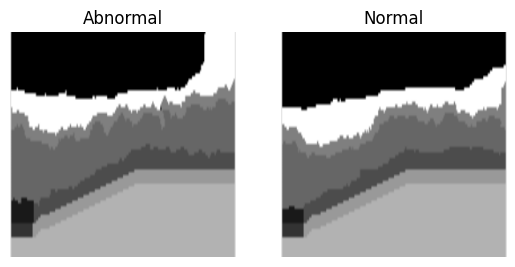

In [13]:
# Step 7: Visualization
def visualize_classification(images, labels):
    for i, img in enumerate(images):
        plt.subplot(1, 2, labels[i] + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Normal" if labels[i] == 0 else "Abnormal")
        plt.axis('off')
    plt.show()

# Visualize the classification results
visualize_classification(images, labels)

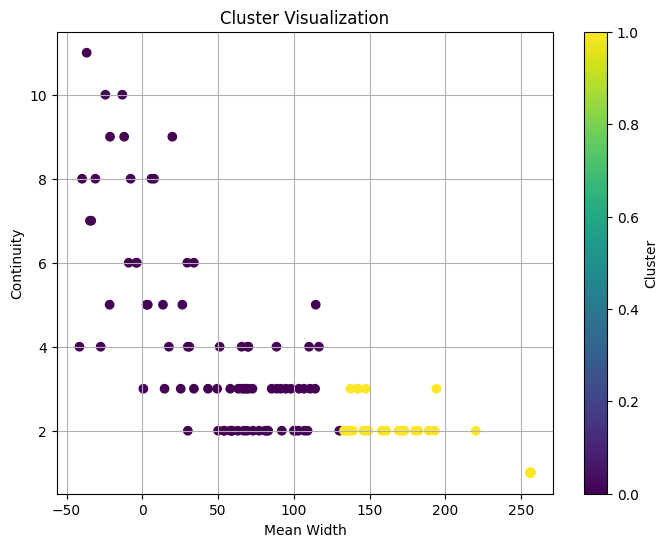

In [14]:
import matplotlib.pyplot as plt

# Visualize clusters
def visualize_clusters(features, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Mean Width')
    plt.ylabel('Continuity')
    plt.title('Cluster Visualization')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

# Visualize clusters
visualize_clusters(image_features, labels)